# In this project we're going to be using Transfer Learning and machine learning to help us identify different breeds of dogs.

To do this, we'll be using data from the Kaggle dog breed identification competition. It consists of a collection of 10,000+ labelled images of 120 different dog breeds.

We're going to go through the following TensorFlow/Deep Learning workflow: 

1. Get data ready (download from Kaggle, store, import).
2. Prepare the data (preprocessing, the 3 sets, X & y).
3. Choose and fit/train a model (TensorFlow Hub, tf.keras.applications, TensorBoard, EarlyStopping).
4. Evaluating a model (making predictions, comparing them with the ground truth labels).
5. Improve the model through experimentation (start with 1000 images, make sure it works, increase the number of images).
6. Save, sharing and reloading your model.

For preprocessing our data, we're going to use TensorFlow 2.x. The whole premise here is to get our data into Tensors (arrays of numbers which can be run on GPUs) and then allow a machine learning model to find patterns between them.

For our machine learning model, we're going to be using a pretrained deep learning model from TensorFlow Hub.

The process of using a pretrained model and adapting it to your own problem is called transfer learning. We do this because rather than train our own model from scratch (could be timely and expensive), we leverage the patterns of another model which has been trained to classify images.


# Getting our workspace ready

Before we get started, since we'll be using TensorFlow 2.x and TensorFlow Hub (TensorFlow Hub), let's import them.
And we'll also check if we're using a GPU.

In [24]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

# Check for GPU
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.1.0
Hub version: 0.7.0
GPU not available :(


# Getting data ready

Since much of machine learning is getting your data ready to be used with a machine learning model, we'll take extra care getting it setup. I have downloaded the data from kaggle and saved it in my current directory with folder name 'data'

### Accessing the data
Let's start with labels.csv which contains all of the image ID's and their assosciated dog breed (our data and labels).

In [25]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("data/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     d583fbee2a4c69e9af446ff6939ed478  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


Looking at this, we can see there are 10222 different ID's (meaning 10222 different images) and 120 different breeds.

Let's figure out how many images there are of each breed.

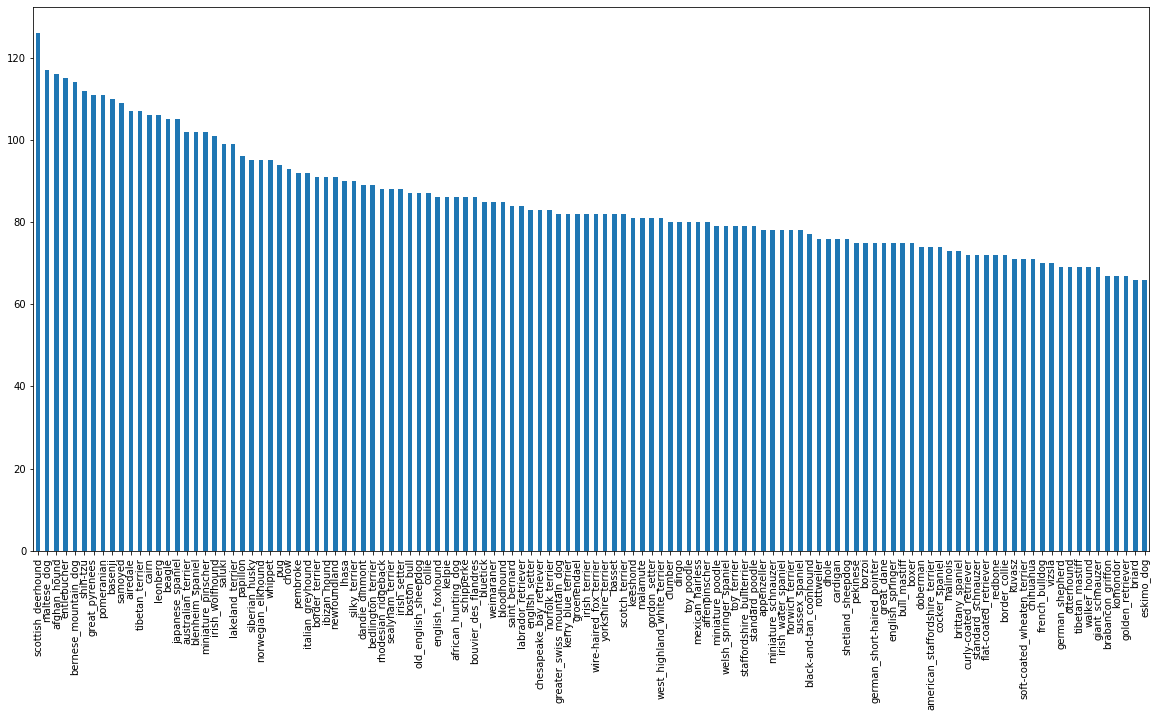

In [26]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10));


Okay sweet. If we were to roughly draw a line across the middle of the graph, we would see there's about 60+ images for each dog breed.

This is a good amount as for some of their vision products Google recommends a minimum of 10 images per class to get started. And as you might imagine, the more images per class available, the more chance a model has to figure out patterns between them.


Let's check out one of the images.

Note: Loading an image file for the first time may take a while as it gets loaded into the runtime memory.


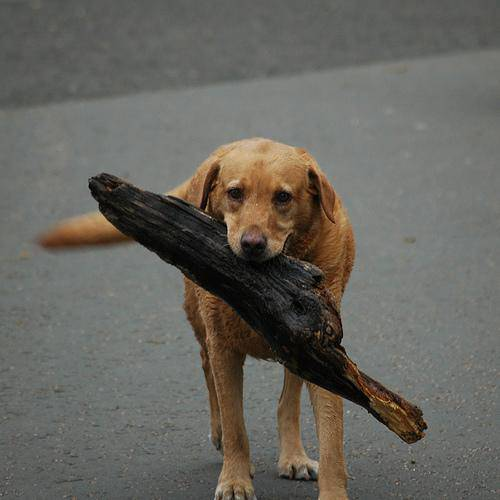

In [27]:
from IPython.display import display, Image

Image("data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg")

### Getting images and their labels

Since we've got the image ID's and their labels in a DataFrame (labels_csv), we'll use it to create:

    1. A list a filepaths to training images
    2. An array of all labels
    3. An array of all unique labels

We'll only create a list of filepaths to images rather than importing them all to begin with. This is because working with filepaths (strings) is much efficient than working with images.

Because we'll use it a few times, we'll save our training files pathname to a variable train_path

In [28]:

# Define our training file path for ease of use
TRAIN_PATH = "data/train/"

# Create pathnames from image ID's
filenames = [TRAIN_PATH + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10 filenames
filenames[:10]


['data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']


Now we've got a list of all the filenames from the ID column of labels_csv, we can compare it to the number of files in our training data directory to see if they line up.

If they do, great. If not, there may be an issue with the code we've written.


In [29]:

# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir(TRAIN_PATH)) == len(filenames):
  print("Yahoo !! Filenames match actual amount of files!")
else:
  print("Oh no !!! Filenames do not match actual amount of files, check the target directory.")


Yahoo !! Filenames match actual amount of files!


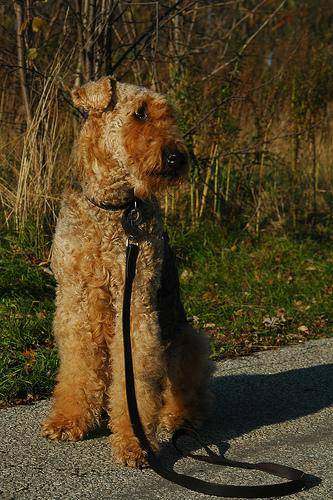

In [30]:
# Just a sanity check directly from a filepath
Image(filenames[5000])

Now we've got our image filepaths together, let's get the labels. We'll take them from labels_csv and turn them into a NumPy array.

In [31]:
labels = labels_csv["breed"].to_numpy() # convert labels column to NumPy array
labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

In [32]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories.")

Number of labels matches number of filenames!


### Converting labels to numbers (categorical)

Finally, since a machine learning model can't take strings as input (what labels currently is), we'll have to convert our labels to numbers.

To begin with, we'll find all of the unique dog breed names.

Then we'll go through the list of labels and compare them to unique breeds and create a list of booleans indicating which one is the real label (True) and which ones aren't (False).

In [33]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)
# unique_breeds

120




The length of unique_breeds should be 120, meaning we're working with images of 120 different breeds of dogs.

Now use unique_breeds to help turn our labels array into an array of booleans


In [34]:
# Example: Turn one label into an array of booleans
print(labels[0])
labels[0] == unique_breeds # use comparison operator to create boolean array

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [35]:

# Turn every label in the dataset into a boolean array
boolean_labels = [label == np.array(unique_breeds) for label in labels]
boolean_labels[:2]


[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

### Why do it like this?

Remember, an important concept in machine learning is converting your data to numbers before passing it to a machine learning model.

In this case, we've transformed a single dog breed name such as boston_bull into a one-hot array.

Let's see an example.


In [36]:

# Example: Turning a boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])[0][0]) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
19
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]



# Creating our own validation set

Since the dataset from Kaggle doesn't come with a validation set (a split of the data we can test our model on before making final predicitons on the test set), let's make one.

We could use Scikit-Learn's train_test_split function or we could simply make manual splits of the data.

For accessibility later, let's save our filenames variable to X (data) and our labels to y

In [37]:
# Setup X & y variables
X = filenames
y = boolean_labels

print(f"Number of training images: {len(X)}")
print(f"Number of labels: {len(y)}")

Number of training images: 10222
Number of labels: 10222


### Starting small

Since we're working with 10,000+ images, it's a good idea to work with a portion of them to make sure things are working before training on them all.

This is because computing with 10,000+ images could take a fairly long time. And our goal when working through machine learning projects is to reduce the time between experiments.

Let's start experimenting with 1000 and increase it as we need.


In [38]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000
NUM_IMAGES

1000

Now let's split our data into training and validation sets. We'll use and 80/20 split (80% training data, 20% validation data).

In [39]:
# Import train_test_split from Scikit-Learn
from sklearn.model_selection import train_test_split

# Split them into training and validation using NUM_IMAGES 
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES], 
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)


(800, 800, 200, 200)

In [40]:

# Check out the training data (image file paths and labels)
X_train[:5], y_train[:2]


(['data/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'data/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'data/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'data/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'data/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False

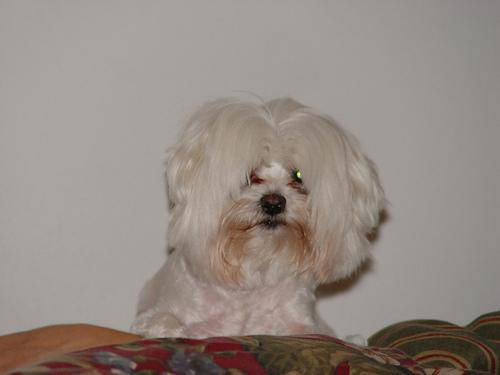

In [41]:
Image(X_train[2])


# Preprocessing images (turning images into Tensors)

Our labels are in numeric format but our images are still just file paths.

Since we're using TensorFlow, our data has to be in the form of Tensors.

A Tensor is a way to represent information in numbers. If you're familar with NumPy arrays, a Tensor can be thought of as a combination of NumPy arrays, except with the special ability to be used on a GPU.

Because of how TensorFlow stores information (in Tensors), it allows machine learning and deep learning models to be run on GPUs (generally faster at numerical computing).

To preprocess our images into Tensors we're going to write a function which does a few things:

    1. Takes an image filename as input.
    2. Uses TensorFlow to read the file and save it to a variable, image.
    3. Turn our image (a jpeg file) into Tensors.
    4. Resize the image to be of shape (224, 224).
    5. Return the modified image.

You might be wondering why (224, 224), which is (heigh, width). It's because this is the size of input our model (we'll see this soon) takes, an image which is (224, 224, 3).

3 is the number of color channels per pixel, red, green and blue.

Let's make this a little more concrete.


In [42]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42]) # read in an image
image.shape


(257, 350, 3)

In [43]:
## you can easily convert it to a Tensor using tf.constant().
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

 ## Let's build that function we were talking about.

In [44]:


# Define image size
IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
                          
  # Turn the jpeg image into numerical Tensor with 3 color channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
                          
  # Convert the color channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
                          
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
                          
  return image

## Function needed to associate image with labels

In [45]:


# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label




# Creating data batches

Wonderful. Now we've got a function to convert our images into Tensors, we'll now build one to turn our data into batches (more specifically, a TensorFlow BatchDataset).

## What's a batch?

A batch (also called mini-batch) is a small portion of your data, say 32 (32 is generally the default batch size) images and their labels. In deep learning, instead of finding patterns in an entire dataset at the same time, you often find them one batch at a time.

Let's say you're dealing with 10,000+ images (which we are). Together, these files may take up more memory than your GPU has. Trying to compute on them all would result in an error.

Instead, it's more efficient to create smaller batches of your data and compute on one batch at a time.

TensorFlow is very efficient when your data is in batches of (image, label) Tensors. So we'll build a function to do create those first. We'll take advantage of of process_image function at the same time.

We'll be dealing with 3 different sets of data (training, validation and test), we'll make sure the function can accomodate for each set.

We'll set a default batch size of 32 because according to Yann Lecun (one of the OG's of deep learning), friends don't let friends train with batch sizes over 32.


In [46]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels
    
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

## Create training and validation data batches


In [110]:
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


## Check out the different attributes of our data batches

In [48]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

# Visualizing Data Batches

In [51]:
# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(20, 20))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn gird lines off
    plt.axis("off")

## Numpy iterator for batch data

To make computation efficient, a batch is a tighly wound collection of Tensors.

So to view data in a batch, we've got to unwind it.
We can do so by calling the as_numpy_iterator() method on a data batch.

This will turn our data batch into something which can be iterated over.

Passing an iterable to next() will return the next item in the iterator. In our case, next will return a batch of 32 images and label pairs

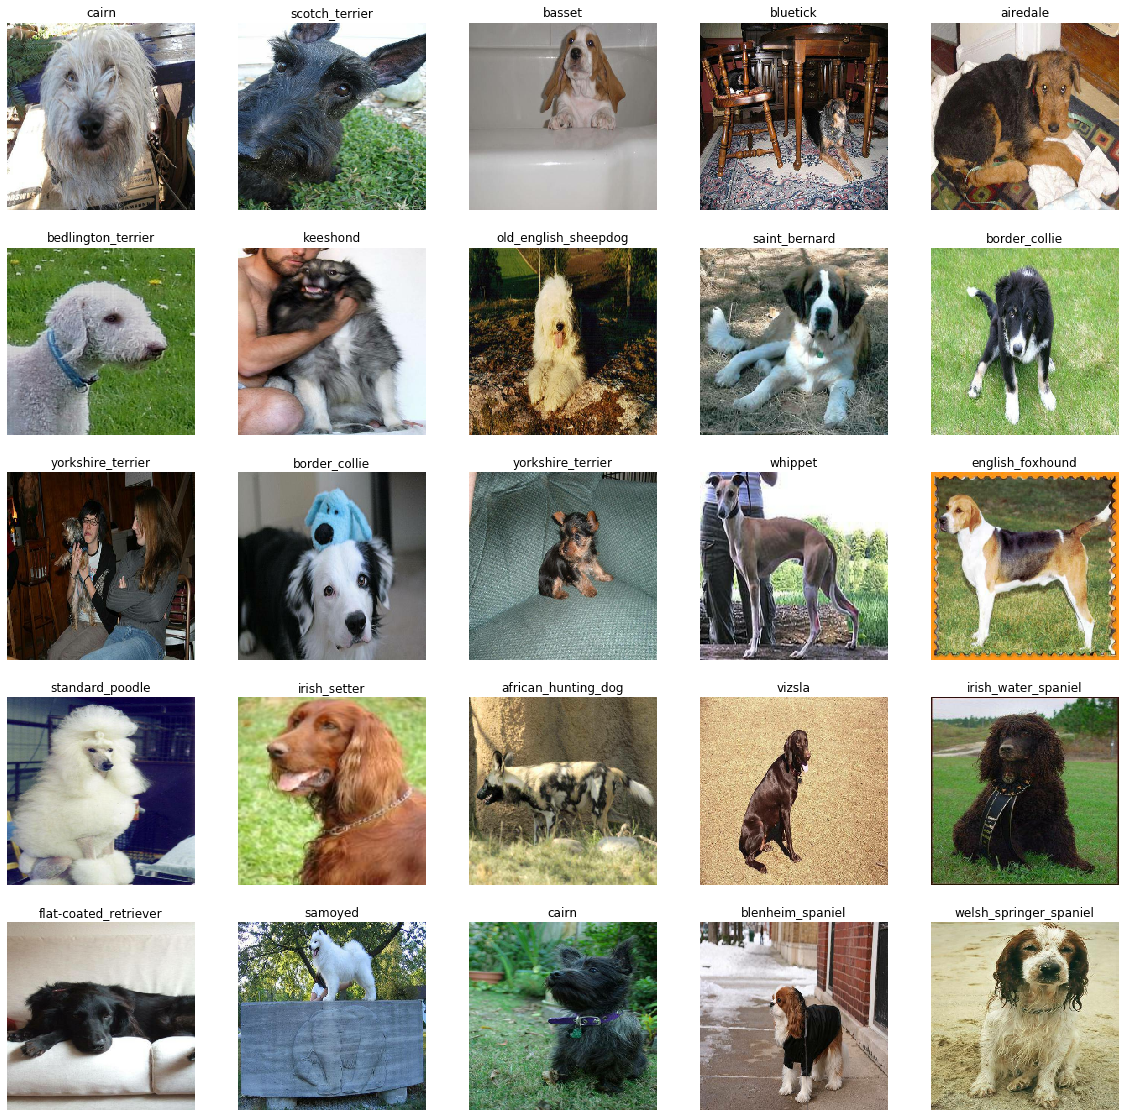

In [111]:
# Visualize training images from the training data batch

train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)


#  Creating and training a model

Now our data is ready, let's prepare it modelling. We'll use an existing model from TensorFlow Hub.

TensorFlow Hub is a resource where you can find pretrained machine learning models for the problem you're working on.

Using a pretrained machine learning model is often referred to as $Transfer$ $Learning$

## Why use a pretrained model?

Building a machine learning model and training it on lots from scratch can be expensive and time consuming.

Transfer learning helps eliviate some of these by taking what another model has learned and using that information with your own problem.

### How do we choose a model?

Since we know our problem is image classification (classifying different dog breeds), we can navigate the TensorFlow Hub page by our problem domain (image).

We start by choosing the image problem domain, and then can filter it down by subdomains, in our case, image classification.

Doing this gives a list of different pretrained models we can apply to our task.

Clicking on one gives us information about the model as well as instructions for using it.

For example, clicking on the mobilenet_v2_130_224 model, tells us this model takes an input of images in the shape 224, 224. It also says the model has been trained in the domain of image classification.

Let's try it out.

# Building a model

Before we build a model, there are a few things we need to define:

    1. The input shape (images, in the form of Tensors) to our model.
    2. The output shape (image labels, in the form of Tensors) of our model.
    3. The URL of the model we want to use.

These things will be standard practice with whatever machine learning model you use. And because we're using TensorFlow, everything will be in the form of Tensors.

In [54]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds) # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"


## Setting up model using Keras

There are many ways of building a model in TensorFlow but one of the best ways to get started is to use the Keras API.

Defining a deep learning model in Keras can be as straightforward as saying, "here are the layers of the model, the input shape and the output shape, let's go!"

Knowing this, let's create a function which:

    1. Takes the input shape, output shape and the model we've chosen's URL as parameters.
    2. Defines the layers in a Keras model in a sequential fashion (do this first, then this, then that).
    3. Compiles the model (says how it should be evaluated and improved).
    4. Builds the model (tells it what kind of input shape it'll be getting).
    5. Returns the model.


In [58]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
        
      hub.KerasLayer(MODEL_URL), # Layer 1 (input layer), TensorFlow Hub layer
        
      tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), # Our model wants to reduce this (how wrong its guesses are)
      optimizer=tf.keras.optimizers.Adam(), # A friend telling our model how to improve its guesses
      metrics=["accuracy"] # We'd like this to go up
  )

  # Build the model
  model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting
  
  return model



## What is the above code doing ?

### STEP 1 : Creating the layers

The first layer we use is the model from TensorFlow Hub (hub.KerasLayer(MODEL_URL). So our first layer is actually an entire model (many more layers). This input layer takes in our images and finds patterns in them based on the patterns mobilenet_v2_130_224 has found.

The next layer (tf.keras.layers.Dense()) is the output layer of our model. It brings all of the information discovered in the input layer together and outputs it in the shape we're after, 120 (the number of unique labels we have).

##### The activation="softmax" parameter tells the output layer, we'd like to assign a probability value to each of the 120 labels somewhere between 0 & 1. 
The higher the value, the more the model believes the input image should have that label. If we were working on a binary classification problem, we'd use activation="sigmoid"

### STEP 2: Compiling the model

Let's say you're at the international hill descending championships. Where you start standing on top of a hill and your goal is to get to the bottom of the hill. The catch is you're blindfolded.

Luckily, your friend Adam is standing at the bottom of the hill shouting instructions on how to get down.

At the bottom of the hill there's a judge evaluating how you're doing. They know where you need to end up so they compare how you're doing to where you're supposed to be. Their comparison is how you get scored.

Transferring this to model.compile() terminology:

    a. loss - The height of the hill is the loss function, the models goal is to minimize this, getting to 0 (the bottom of the hill) means the model is learning perfectly.
    
    b. optimizer - Your friend Adam is the optimizer, he's the one telling you how to navigate the hill (lower the loss function) based on what you've done so far. His name is Adam because the Adam optimizer is a great general which performs well on most models.
    
    c. metrics - This is the onlooker at the bottom of the hill rating how well your perfomance is. Or in our case, giving the accuracy of how well our model is predicting the correct image label.


### STEP 3: Building the model

We use model.build() whenever we're using a layer from TensorFlow Hub to tell our model what input shape it can expect.

In this case, the input shape is [None, IMG_SIZE, IMG_SIZE, 3] or [None, 224, 224, 3] or [batch_size, img_height, img_width, color_channels].

Batch size is left as None as this is inferred from the data we pass the model. In our case, it'll be 32 since that's what we've set up our data batches as.

Now we've gone through each section of the function, let's use it to create a model.

We can call summary() on our model to get idea of what our model looks like.

In [59]:

# Create a model and check its details
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


##### Parameters

The non-trainable parameters are the patterns learned by mobilenet_v2_130_224 and the trainable parameters are the ones in the dense layer we added.
This means the main bulk of the information in our model has already been learned and we're going to take that and adapt it to our own problem.


# Creating callbacks (things to help our model)

We've got a model ready to go but before we train it we'll make some callbacks.

Callbacks are helper functions a model can use during training to do things such as save a models progress, check a models progress or stop training early if a model stops improving.

The two callbacks we're going to add are a TensorBoard callback and an Early Stopping callback.

### TensorBoard Callback

TensorBoard helps provide a visual way to monitor the progress of your model during and after training.

It can be used directly in a notebook to track the performance measures of a model such as loss and accuracy.

To set up a TensorBoard callback and view TensorBoard in a notebook, we need to do three things:

    1. Load the TensorBoard notebook extension.
    2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's fit() function.
    3. Visualize our models training logs using the %tensorboard magic function (we'll do this later on)

In [61]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard



### Early Stopping Callback¶

Early stopping helps prevent overfitting by stopping a model when a certain evaluation metric stops improving. If a model trains for too long, it can do so well at finding patterns in a certain dataset that it's not able to use those patterns on another dataset it hasn't seen before (doesn't generalize).

It's basically like saying to our model, "keep finding patterns until the quality of those patterns starts to go down."


In [63]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3) # stops after 3 rounds of no improvements


# Training a model

The final parameter we'll define before training is NUM_EPOCHS (also known as number of epochs).

NUM_EPOCHS defines how many passes of the data we'd like our model to do. A pass is equivalent to our model trying to find patterns in each dog image and see which patterns relate to each label.

If NUM_EPOCHS=1, the model will only look at the data once and will probably score badly because it hasn't a chance to correct itself. It would be like you competing in the international hill descent championships and your friend Adam only being able to give you 1 single instruction to get down the hill.

Let's create a simple function which trains a model. The function will:

    1. Create a model using create_model().
    
    2. Setup a TensorBoard callback using create_tensorboard_callback() (we do this here so it creates a log directory of the current date and time).
    
    3. Call the fit() function on our model passing it the training data, validation data, number of epochs to train for and the callbacks we'd like to use.
    
    4. Return the fitted model.


In [64]:
# How many rounds should we get the model to look through the data?
NUM_EPOCHS = 2

# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[tensorboard, early_stopping])
  
  return model


# Final Set is to fit the model to the data


In [65]:
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Train for 25 steps, validate for 7 steps
Epoch 1/2
25/25 [==============================] - 28s 1s/step - loss: 4.6733 - accuracy: 0.0925 - val_loss: 3.7237 - val_accuracy: 0.2450
Epoch 2/2
25/25 [==============================] - 28s 1s/step - loss: 1.7224 - accuracy: 0.6737 - val_loss: 2.3584 - val_accuracy: 0.4500


It looks like our model might be overfitting (getting far better results on the training set than the validation set). Some ways to prevent overfitting is 
    
    1. Reduce the network capacity by removing layers or reducing the number of elements in the hidden layers.
    
    2. Apply regularization, which comes down to adding a cost to the loss function for large weights.
    
    3. Use Dropout layers, which will randomly remove certain features by setting them to zero.

Note: Overfitting to begin with is a good thing. It means our model is learning something


### Checking the TensorBoard logs

Now our model has been trained, we can make its performance visual by checking the TensorBoard logs.

The TensorBoard magic function (%tensorboard) will access the logs directory we created earlier and viualize its contents. We can definitely see our model is learning something. The validation accuracy got to 65% in only a few minutes. 

This means, if we were to scale up the number of images and the number of epochs , hopefully we'd see the accuracy increase.


In [67]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 8177), started 0:01:53 ago. (Use '!kill 8177' to kill it.)


# Making and evaluating predictions using a trained model

Before we scale up and train on more data, let's see some other ways we can evaluate our model. Because although accuracy is a pretty good indicator of how our model is doing, it would be even better if we could could see it in action.

Making predictions with a trained model is as calling predict() on it and passing it data in the same format the model was trained on.


In [68]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1) # verbose shows us how long there is to go
predictions

7/7 [==============================] - 6s 815ms/step


array([[3.1721175e-03, 2.9035070e-04, 8.3028553e-03, ..., 8.1443135e-04,
        2.8977366e-04, 2.2309853e-02],
       [5.8685481e-03, 6.4172538e-04, 3.6110536e-03, ..., 2.7426984e-03,
        6.0082059e-03, 1.2272144e-02],
       [4.6273498e-04, 7.2312797e-04, 1.0697963e-03, ..., 3.3155959e-02,
        5.4461096e-04, 7.4053317e-04],
       ...,
       [5.4074360e-05, 1.7686805e-03, 6.0004118e-04, ..., 9.6503808e-04,
        5.6535415e-03, 7.4818725e-04],
       [1.5442866e-02, 1.8802629e-03, 5.0467975e-04, ..., 7.6696533e-04,
        1.4850256e-03, 1.1126166e-02],
       [3.9232359e-03, 1.4513618e-03, 1.1011377e-03, ..., 8.2718820e-04,
        1.2681529e-02, 5.3662201e-04]], dtype=float32)

In [69]:

# Check the shape of predictions
predictions.shape

(200, 120)



Making predictions with our model returns an array with a different value for each label.

In this case, making predictions on the validation data (200 images) returns an array (predictions) of arrays, each containing 120 different values (one for each unique dog breed).

These different values are the probabilities or the likelihood the model has predicted a certain image being a certain breed of dog. The higher the value, the more likely the model thinks a given image is a specific breed of dog.

Let's see how we'd convert an array of probabilities into an actual label.


In [70]:


# First prediction
# print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(predictions[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {unique_breeds[np.argmax(predictions[0])]}") # the predicted label



Max value (probability of prediction): 0.1486312747001648
Sum: 1.0
Max index: 17
Predicted label: border_terrier


 ### Lets build a function to convert prediction probabilities into predicted labels.

In [71]:

# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label


'border_terrier'



Wonderful! Now we've got a list of all different predictions our model has made, we'll do the same for the validation images and validation labels.

Remember, the model hasn't trained on the validation data, during the fit() function, it only used the validation data to evaluate itself. So we can use the validation images to visually compare our models predictions with the validation labels.

Since our validation data (val_data) is in batch form, to get a list of validation images and labels, we'll have to unbatch it (using unbatch()) and then turn it into an iterator using as_numpy_iterator().

Let's make a small function to do so.


In [116]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

# Visualize Prediction

We want to be able to view an image, its predicted label and its actual label (true label).

The create a function that will:

    1. Take an array of prediction probabilities, an array of truth labels, an array of images and an integer.
    
    2. Convert the prediction probabilities to a predicted label.
    
    3. Plot the predicted label, its predicted probability, the truth label and target image on a single plot.


In [118]:
def plot_pred(prediction_probabilities, labels, images, n=1):
    """
    View the prediction, ground truth label and image for sample n.
    """
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

    # Get the pred label
    pred_label = get_pred_label(pred_prob)

    # Plot image & remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    # Change the color of the title depending on if the prediction is right or wrong
    if pred_label == true_label:
    color = "green"
    else:
    color = "red"

    plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

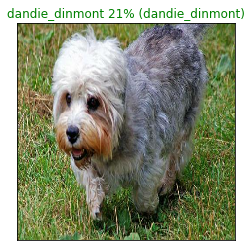

In [128]:


# View an example prediction, original image and truth label
plot_pred(
    prediction_probabilities=predictions,
    labels=val_labels,
    images=val_images,
    n=30)

## Visualize other predictions in the multiclass softmax

Since we're working with a multi-class problem (120 different dog breeds), it would also be good to see what other guesses our model is making. More specifically, if our model predicts a certain label with 24% probability, what else did it predict?

Let's build a function to demonstrate. The function will:

    1. Take an input of a prediction probabilities array, a ground truth labels array and an integer.
    
    2. Find the predicted label using get_pred_label().
    
    3. Find the top 10:
        a. Prediction probabilities indexes
        b. Prediction probabilities values
        c. Prediction labels
    
    4. Plot the top 10 prediction probability values and labels, coloring the true label green.


In [127]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
    """
    Plots the top 10 highest prediction confidences along with
    the truth label for sample n.
    """
    pred_prob, true_label = prediction_probabilities[n], labels[n]

    # Get the predicted label
    pred_label = get_pred_label(pred_prob)

    # Find the top 10 prediction confidence indexes
    top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
    
    # Find the top 10 prediction confidence values
    top_10_pred_values = pred_prob[top_10_pred_indexes]
    
    # Find the top 10 prediction labels
    top_10_pred_labels = unique_breeds[top_10_pred_indexes]

    # Setup plot
    top_plot = plt.bar(np.arange(len(top_10_pred_labels)), 
                     top_10_pred_values, 
                     color="grey")
    plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

    # Change color of true label
    if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
    else:
        pass

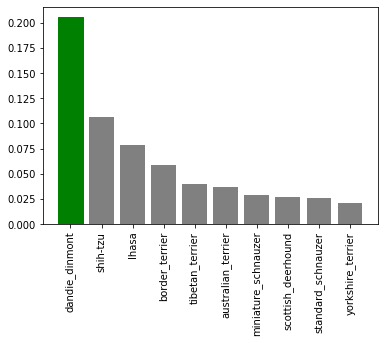

In [129]:

# View an example prediction
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=30)



# Visualize to Evaluate our model

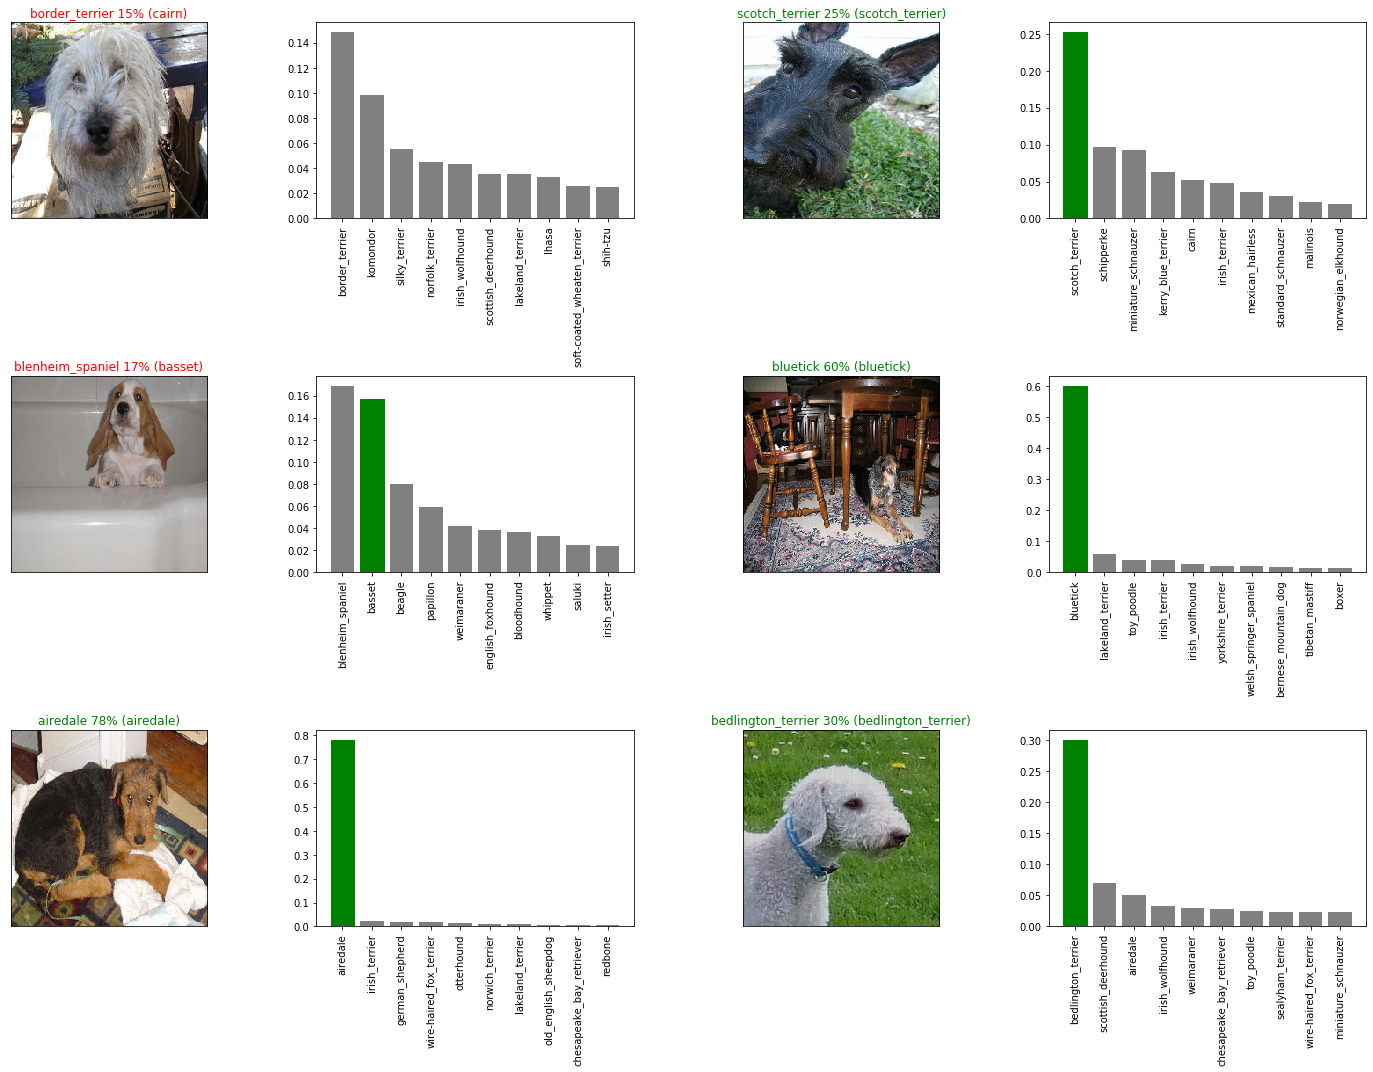

In [130]:
# Let's check a few predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()


# Saving and reloading a model

After training a model, it's a good idea to save it. Saving it means you can share it with colleagues, put it in an application and more importantly, won't have to go through the potentially expensive step of retraining it.

The format of an entire saved Keras model is h5. So we'll make a function which can take a model as input and utilise the save() method to save it as a h5 file to a specified directory.


In [131]:


def save_model(model, suffix=None):
    """
    Saves a given model in a models directory and appends a suffix (str)
    for clarity and reuse.
    """
    # Create model directory with current time
    modeldir = os.path.join("models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
    model_path = modeldir + "-" + suffix + ".h5" # save format of model
    print(f"Saving model to: {model_path}...")
    model.save(model_path)
    return model_path





If we've got a saved model, we'd like to load it, let's create a function which can take a model path and use the tf.keras.models.load_model() function to load it into the notebook.

Because we're using a component from TensorFlow Hub (hub.KerasLayer) we'll have to pass this as a parameter to the custom_objects parameter.


In [132]:


def load_model(model_path):
    """
    Loads a saved model from a specified path.
    """
    print(f"Loading saved model from: {model_path}")
    model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
    return model



In [134]:
# Save our model trained on 1000 images
saved_1000_image_model_path = save_model(model, suffix="1000-images-Adam")

Saving model to: models/20200216-20011581908488-1000-images-Adam.h5...


In [135]:
# Load our model trained on 1000 images
loaded_model_1000_images = load_model(saved_1000_image_model_path)

Loading saved model from: models/20200216-20011581908488-1000-images-Adam.h5


### Compare the two models (the original one and loaded one). We can do so easily using the evaluate() method.

In [136]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 5s 734ms/step - loss: 2.3584 - accuracy: 0.4500


[2.3584131683622087, 0.45]

In [137]:
# Evaluate the loaded model
loaded_model_1000_images.evaluate(val_data)

7/7 [==============================] - 6s 832ms/step - loss: 2.3584 - accuracy: 0.4500


[2.3584131683622087, 0.45]